# **Section 1 — Project Overview: Recipe Rating Predictor**

The goal of this project is to build a **recipe-rating predictor** that estimates how a user would rate a recipe on a **1–5 star scale**, using the Food.com Recipes and Interactions dataset from Kaggle.

This dataset includes:

- **231,637 raw recipes** with text, nutrition, ingredients, and cooking steps  
- **~1.1 million user–recipe interactions** (ratings, timestamps, reviews)  
- **Preprocessed datasets**:
  - **PP_recipes**  
    - Tokenized ingredients  
    - Cooking techniques  
    - Nutrition features (calories, fat, sugar, etc.)  
    - Mapped ingredient IDs  
  - **PP_users**  
    - User histories  
    - Techniques and ingredients frequently used  
  - And more, that will be explored in depth in Section 2. 

---








## **1.1 Predictive Task**

The supervised learning task is:

### Given a user embedding and a recipe embedding, predict the rating that the user would assign to that recipe.

This can be seen as similar to to the "Rating Prediction" task in Assignment 1 of this class. 

---

## **Potential Model Inputs (not sure if this is needed here)**

### **Recipe Embedding**

Constructed using:
- Tokenized ingredient lists, either via the pre-processed dataset or another method
- Nutrition features (calories, protein, fat, sugar)  
- Cooking techniques extracted from instructions  
- Dimensionality-reduced embeddings (SVD/PCA)

### **User Embedding**

Constructed using:
- Weighted average of past recipe embeddings  
- Rating-based weights (optional)  
- Frequent ingredients or techniques  
- Metadata from PP_users  

---

## **Model Output**

A continuous rating prediction:

$\hat{y} \in [1,5]$

This is a **supervised regression problem**, compatible with:
- Linear Regression  
- k-NN Regression  
- Latent Factor Model
- Baseline heuristics (global mean, recipe mean, user mean)  

---

# **1.2 Evaluation Strategy**


## **Train–Test Setup**

- Utilize the train, test, validation split already created by Kaggle

---

## **Evaluation Metrics**

### **RMSE — Root Mean Squared Error**
- Heavily penalizes large mistakes  
- Benchmark metric in recommender systems  

### **MAE — Mean Absolute Error**
- Interpretable: “on average, the model is off by X stars”  
- Robust to outliers

Together, RMSE and MAE capture:
- **Average prediction error** (MAE)  
- **Sensitivity to large deviations** (RMSE)

---

## **Hyperparameter Tuning (not sure if this is needed)**

Models such as k-NN and ridge regression require tuning:

- Number of neighbors (**K**)  
- Regularization strength  
- Embedding dimensionality  

We use a **validation split or cross-validation** for fair comparisons.

---

# **1.3 Baseline Models**

To ensure the model meaningfully improves over simple heuristics, we include several baseline predictors.

### **Baseline 1 — Global Mean Predictor**

$\hat{y} = \bar{r}$

Predicts the overall mean rating for every user–recipe pair.

### **Baseline 2 — Recipe Mean Predictor**

$\hat{y}_{u,i} = \bar{r}_i$

Predicts how recipe *i* is typically rated.  
Strong baseline since some recipes are universally liked/disliked.

### **Baseline 3 — User Mean Predictor**

$\hat{y}_{u,i} = \bar{r}_u$


Models each user's average generosity or strictness.

---

# **1.4 Assessing the Validity of Predictions**

## **A. Quantitative Validity**
- RMSE/MAE comparisons vs. baselines  
- Error distribution plots  
- Predicted vs. true rating scatterplots  

## **B. User-Level Validity**
- Which users are predicted accurately?  
- Does performance degrade for users with fewer interactions?  
- Does the model systematically overpredict/underpredict certain rating levels?  

## **C. Recipe-Level Validity**
- Performance on popular vs. niche recipes  
- Behavior on high-variance recipes (mixed opinions)  
- Whether accuracy correlates with recipe clusters (e.g., cuisine type)

---

# Section 2: Exploratory analysis, data collection, pre-processing, and discussion


## **2.1 Context**

The dataset used in this project is the **Food.com Recipes and Interactions Dataset**, originally collected from Food.com (formerly GeniusKitchen). It contains:

- **231,637 raw recipes**
- **~1.1 million user–recipe interactions** (ratings, reviews, timestamps)
- **18 years of historical data** (1999–2018)

This dataset was introduced in the research paper:

**Majumder, Li, Ni, & McAuley (EMNLP 2019)**  
*Generating Personalized Recipes from Historical User Preferences*

---

## **Dataset Structure**

### **1. RAW Files**

- `RAW_recipes.csv`  
- `RAW_interactions.csv`  

These contain:
- Original scraped text  
- Metadata  
- Ingredient lists  
- Cooking steps  
- User reviews  

### **2. Preprocessed (PP) Files**

- `PP_recipes.csv`  
- `PP_users.csv`  

These are aligned for ML tasks and include:
- GPT-tokenized names, ingredients, and steps  
- One-hot encoded cooking techniques  
- Ingredient ID lists  
- Per-user sequences of viewed items and ratings  
- Calorie-level labels  

---

## **2.2 Additional Pre-Processing**

While the dataset already contains some pre processed columns, we would like to add additional columns that may be useful for feature engineering down the line. 


### Load all files

In [5]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

pp_recipes = pd.read_csv("data/PP_recipes.csv")
pp_users = pd.read_csv("data/PP_users.csv")
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_interactions = pd.read_csv("data/RAW_interactions.csv")
ingr_map = pd.read_pickle("data/ingr_map.pkl")


### Converting String-Encoded Lists to Python Objects

Many PP columns contain lists stored as strings (e.g., "[1, 2, 3]"). This is essential before computing statistics or building embeddings. We convert them into actual Python lists:

In [6]:
list_cols = ["name_tokens", "ingredient_tokens", "steps_tokens",
             "techniques", "ingredient_ids"]

for col in list_cols:
    pp_recipes[col] = pp_recipes[col].apply(ast.literal_eval)


For PP_users:

In [7]:
user_list_cols = ["techniques", "items", "ratings"]

for col in user_list_cols:
    pp_users[col] = pp_users[col].apply(ast.literal_eval)


## Recipe-Level Exploratory Analysis

### Ingredient Count per Recipe

We compute and visualize the number of ingredients:

Text(0, 0.5, 'Count')

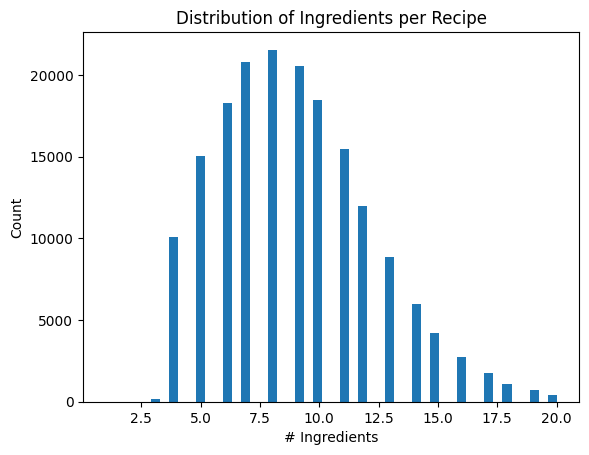

In [8]:
pp_recipes["n_ingredients"] = pp_recipes["ingredient_ids"].apply(len)

plt.hist(pp_recipes["n_ingredients"], bins=50)
plt.title("Distribution of Ingredients per Recipe")
plt.xlabel("# Ingredients"); plt.ylabel("Count")


**Findings**: Most recipes contain between 5–12 ingredients, with a long tail for more complex dishes.

### Cooking Technique Frequencies

The original PP files have techniques as a one-hot encoded vector. We found the original list of techniques (in order) from the Kaggle poster's github repo, to decode the techniques. This is for us to gain a better understanding of what the data actually contains. 

In [9]:
# Techniques - ordered!
TECHNIQUES_LIST = [
    'bake',
    'barbecue',
    'blanch',
    'blend',
    'boil',
    'braise',
    'brine',
    'broil',
    'caramelize',
    'combine',
    'crock pot',
    'crush',
    'deglaze',
    'devein',
    'dice',
    'distill',
    'drain',
    'emulsify',
    'ferment',
    'freez',
    'fry',
    'grate',
    'griddle',
    'grill',
    'knead',
    'leaven',
    'marinate',
    'mash',
    'melt',
    'microwave',
    'parboil',
    'pickle',
    'poach',
    'pour',
    'pressure cook',
    'puree',
    'refrigerat',
    'roast',
    'saute',
    'scald',
    'scramble',
    'shred',
    'simmer',
    'skillet',
    'slow cook',
    'smoke',
    'smooth',
    'soak',
    'sous-vide',
    'steam',
    'stew',
    'strain',
    'tenderize',
    'thicken',
    'toast',
    'toss',
    'whip',
    'whisk',
]

In [12]:
tech_counts = {}

for row in pp_recipes["techniques"]:
    for i, val in enumerate(row):
        if val == 1:
            tech_counts[i] = tech_counts.get(i, 0) + 1

tech_counts = dict(sorted(tech_counts.items(), key=lambda x: -x[1]))

top_n = 10

for idx, count in list(tech_counts.items())[:top_n]:
    technique = TECHNIQUES_LIST[idx]
    print(f"{technique}: {count}")

bake: 64821
combine: 60136
pour: 48747
boil: 42354
melt: 30865
drain: 29567
blend: 29387
simmer: 29380
skillet: 26825
refrigerat: 20543


Text(0, 0.5, 'Count')

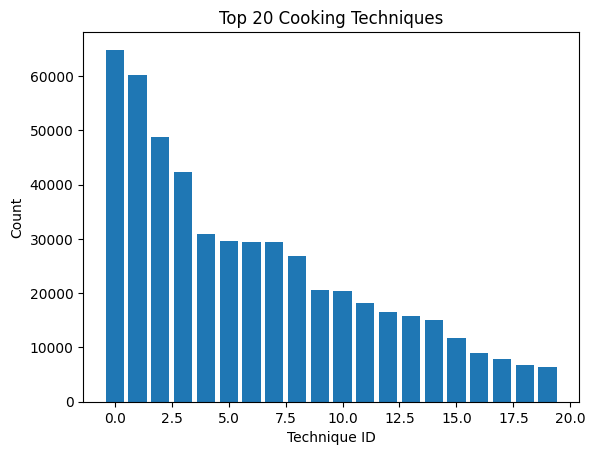

In [11]:
plt.bar(range(20), list(tech_counts.values())[:20])
plt.title("Top 20 Cooking Techniques")
plt.xlabel("Technique ID"); plt.ylabel("Count")

### Step Count Distribution

Text(0, 0.5, 'Count')

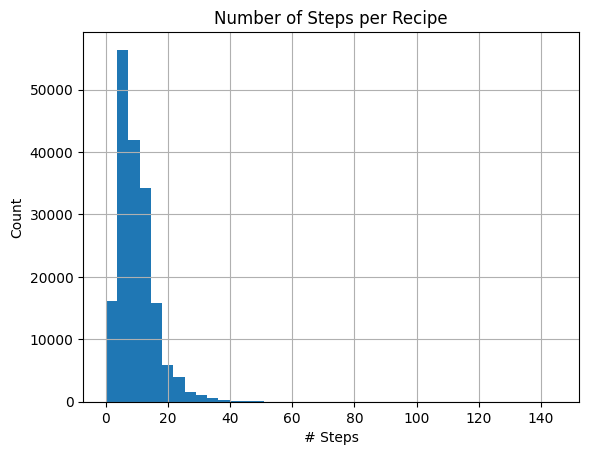

In [13]:
pp_recipes["n_steps"] = raw_recipes["n_steps"]

pp_recipes["n_steps"].hist(bins=40)
plt.title("Number of Steps per Recipe")
plt.xlabel("# Steps"); plt.ylabel("Count")


**Findings**: Most recipes contain 5–9 steps. But there seems to be some outliers.

### Nutrition Processing (RAW → PP)

The RAW nutrition field contains lists of the form "[100.0, 5.0, 10.0, 20.0, 7.0, 2.0, 15.0]"

We parse and expand into named columns:

In [15]:
raw_recipes["nutrition"] = raw_recipes["nutrition"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

nutrition_cols = [
    "calories","total_fat_PDV","sugar_PDV","sodium_PDV",
    "protein_PDV","saturated_fat_PDV","carbs_PDV"
]

nut_df = pd.DataFrame(raw_recipes["nutrition"].tolist(), columns=nutrition_cols)
raw_recipes = pd.concat([raw_recipes.drop(columns=["nutrition"]), nut_df], axis=1)


Then merge back into PP_recipes:

In [16]:
pp_recipes = pp_recipes.merge(
    raw_recipes[["id"] + nutrition_cols], how="left", on="id"
)


In [17]:
pp_recipes.head(1)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_ingredients,n_steps,calories,total_fat_PDV,sugar_PDV,sodium_PDV,protein_PDV,saturated_fat_PDV,carbs_PDV
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]",5,11,228.2,2.0,2.0,8.0,9.0,1.0,15.0


### Nutrition EDA

Text(0.5, 0.98, 'Nutrition Feature Distributions')

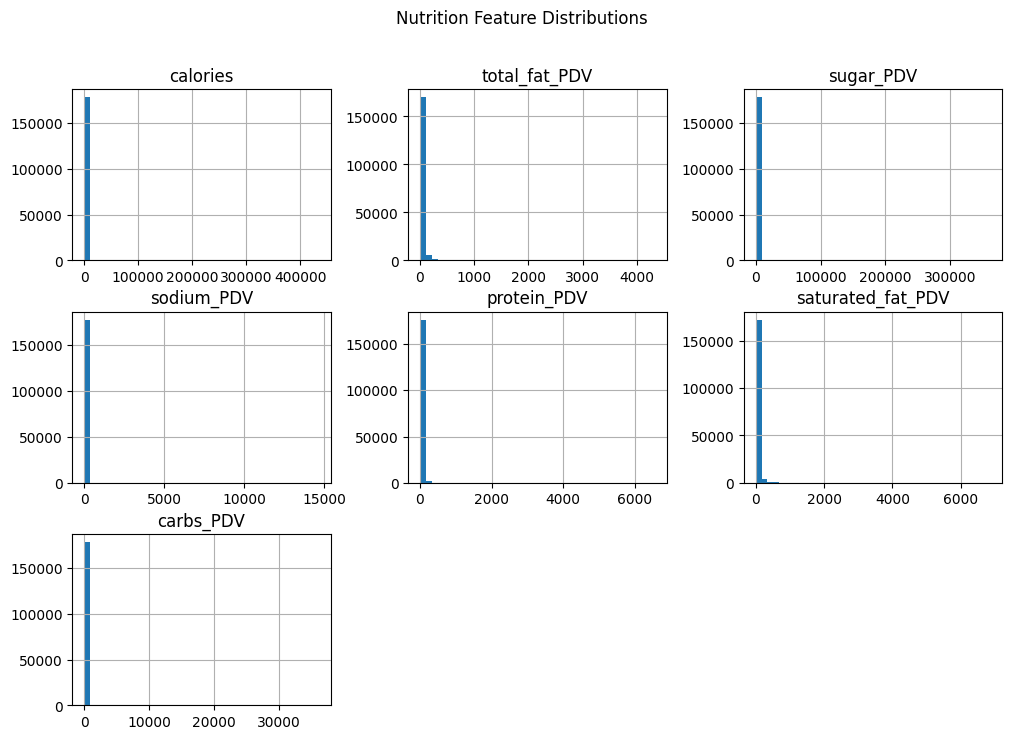

In [19]:
pp_recipes[nutrition_cols].hist(bins=40, figsize=(12,8))
plt.suptitle("Nutrition Feature Distributions")

There are clearly some outliers here!

### Recipe Outlier Removal Using Z-Scores

In [22]:
from scipy.stats import zscore

z_scores = pp_recipes[nutrition_cols].apply(zscore)
pp_recipes = pp_recipes[(z_scores.abs() < 5).all(axis=1)]

Lets try those last plots (Nutrition EDA) again: 

Text(0.5, 0.98, 'Nutrition Feature Distributions')

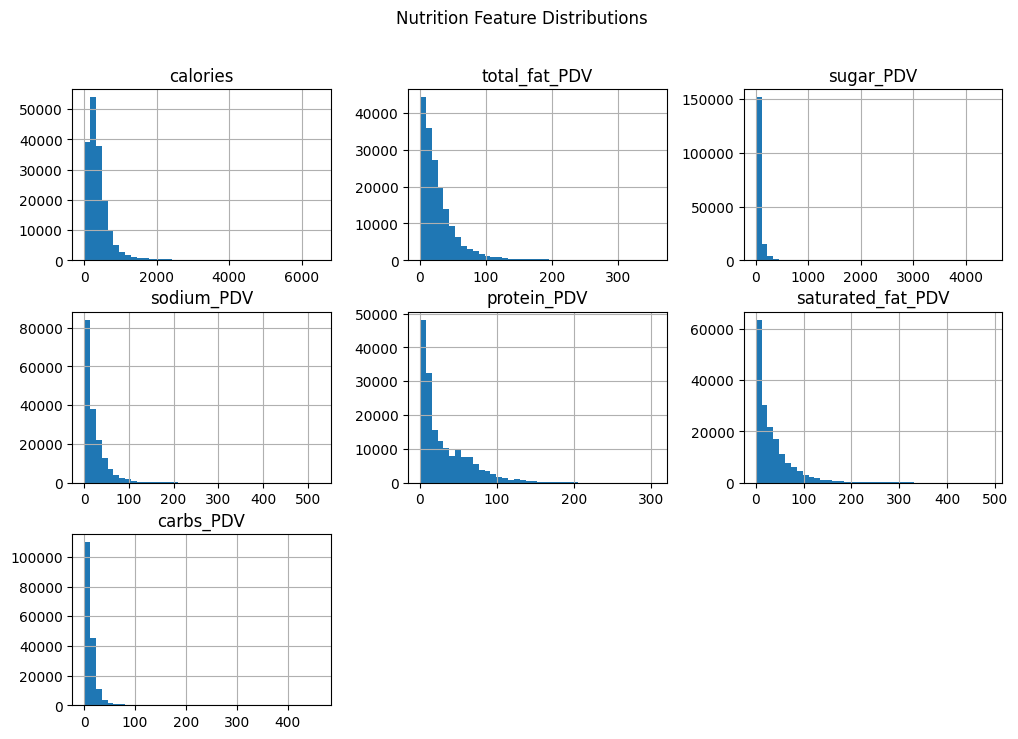

In [23]:
pp_recipes[nutrition_cols].hist(bins=40, figsize=(12,8))
plt.suptitle("Nutrition Feature Distributions")